In [1]:
from ema_workbench import ( 
    ScalarOutcome,
    perform_experiments, 
    RealParameter,
    CategoricalParameter,
    ema_logging, 
    MultiprocessingEvaluator,
    ScalarOutcome,
    ArrayOutcome,
    Constant,
    Model,
    Policy,
    IntegerParameter
)
from ema_workbench.connectors.vensim import VensimModel
from ema_workbench.em_framework import CategoricalParameter
from ema_workbench.em_framework.salib_samplers import get_SALib_problem
from ema_workbench.em_framework.optimization import to_problem, epsilon_nondominated

C:\Users\bern\anaconda3\lib\site-packages\ema_workbench\connectors\__init__.py:29: ImportWarning: netlogo connector not available
  warnings.warn("netlogo connector not available", ImportWarning)
C:\Users\bern\anaconda3\lib\site-packages\ema_workbench\connectors\__init__.py:34: ImportWarning: simio connector not available
  warnings.warn("simio connector not available", ImportWarning)


In [2]:
import matplotlib.pyplot as plt
from ema_workbench.analysis.plotting import lines
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats.kde as kde

C:\Users\bern\anaconda3\lib\site-packages\ema_workbench\analysis\prim.py:30: ImportWarning: altair based interactive inspection not available
  warnings.warn(("altair based interactive " "inspection not available"), ImportWarning)


In [3]:
if __name__ == "__main__":
    ema_logging.log_to_stderr(ema_logging.INFO)

In [4]:
wd = r"./Models" 
model = VensimModel("simpleModel", wd=wd, model_file="Thesismodel new policy.vpmx") 

In [5]:
model.outcomes = [
    #TimeSeriesOutcome("MW installed"),
    ScalarOutcome('Installed capacity (MW)', variable_name='MW installed',function=np.max,kind=ScalarOutcome.MAXIMIZE),
    #TimeSeriesOutcome("LCOH[green hydrogen]"),
    ScalarOutcome('Production costs \N{euro sign}', variable_name='LCOH[green hydrogen]',function=np.min,kind=ScalarOutcome.MINIMIZE),
    #TimeSeriesOutcome("Total CO2 emissions"),
    ScalarOutcome("Avoided CO2 emissions (Mton)", variable_name="Industrial CO2 savings with green hydrogen",function=np.max,kind=ScalarOutcome.MAXIMIZE),
    #TimeSeriesOutcome("Total subsidies"),
    ScalarOutcome("Subsidy costs (\N{euro sign}Million)", variable_name='Total subsidies', function=np.min,kind=ScalarOutcome.MINIMIZE)
]

In [6]:
model.uncertainties = [
#Green H2
    RealParameter("Learning rate",0.04,0.06),
    RealParameter("Innovation cycle",4,6),
    RealParameter("Relative elasticity",-0.8,-0.4),
    RealParameter("Market adaptation speed",0.4,0.8),
    RealParameter("Scaling factor",0.5,2),
    RealParameter("Electrolysis development",0.08,0.31),
    RealParameter("Max efficiency",0.8,0.9),
    RealParameter("CO2 elasticity", 0.4,0.8),
    RealParameter("Market maturity",0.2,0.6),
    RealParameter("Initial CAPEX", 4000, 6500),
    RealParameter("Operation & maintenance costs",0.05,0.15),
#H2 Demand
    RealParameter("Demand substitution rate",0.1,2),
    RealParameter("Price elasticity of demand[Green hydrogen]",-3,-1.5),
    RealParameter("Price elasticity of demand[Blue hydrogen]",-2.5,-1,),
    RealParameter("Price elasticity of demand[Grey hydrogen]",-1,0),
    RealParameter("Substitution delay",1.5,4.5),
    RealParameter("Premium value[Refineries]",0,1000),
    RealParameter("Premium value[Methanol]",0,1000),
    RealParameter("Premium value[Ammonia]",0,1000),
    RealParameter("Premium value[Steel]",0,1000),
    RealParameter("Premium value[Transport]",0,2000),
    RealParameter("Premium value[Synthetic fuels]",0,2000),
    RealParameter("Allocation key SDE",0,0.2),
    RealParameter("Allocation key",0,0.2),
    
# #RES

    RealParameter("Roadmap WOZ",1000,2000),
    RealParameter("Onshore RES increase",0.01,0.04),
    RealParameter("Other additional renewables",0.01,0.04),
    RealParameter("Domestic electrification",0.03,0.05),
    RealParameter("Min Capex",500,2000),
    RealParameter("Policy market size adjustment[Refineries]",0.01,0.03),
    RealParameter("Policy market size adjustment[Methanol]",-0.02,0.02),
    RealParameter("Policy market size adjustment[Transport]",-0.02,0.02),
    RealParameter("Policy market size adjustment[Ammonia]",-0.02,0.02),
    RealParameter("Policy market size adjustment[EFuels]",-0.02,0.02),
    
# #Energy demand
    RealParameter("Transport fuel substitution rate", 0.1,0.2),
    RealParameter("Industrial energy substitution rate",0.1,0.2),
    RealParameter("Long term price effect",0.2,0.4),
    RealParameter("Short term price effect",0.1,0.3),
    RealParameter("Oil price",70,110),
    RealParameter("Coal price",70,110),
    RealParameter("Initial gas price",50,70),
    RealParameter("Initial electricity price",50,70),
    RealParameter("Biofuel price",1900,2100),
    RealParameter("Efuel price",2400,2600),
    RealParameter("Market reaction delay",0.8,1.2),
    RealParameter("Energy carrier demand elasticity",-0.6,-0.4),
    RealParameter("Business cycle",5,7),
    RealParameter("Average GDP growth",0.01,0.03),
    RealParameter("Innovation factor[Synthetic fuels]",0.01,0.02),
    RealParameter("Innovation factor[Biofuels]",0.01,0.02),
    RealParameter("Innovation factor[Electricity]",0.01,0.02),
    RealParameter("Efficiency increase",0.01,0.02)
                  ]

In [7]:
model.constants = [
    Constant("Switch combined tendering", 1),
    Constant("Adaptive policy refineries switch", 1),
]

In [8]:
model.levers = [
    IntegerParameter("Initial ICPEI funds",0,800),
    IntegerParameter("SDE++ fund",0,800),
    RealParameter("Market value creation[refineries]",0.5,1.5),
    RealParameter("Share RES allocated to H2",0.3,0.7)
]

In [9]:
from ema_workbench import Constraint

constraints = [
            Constraint("min capacity", outcome_names="Installed capacity (MW)", function=lambda x: max(0, -x + 40000)),
    Constraint("max subsidy", outcome_names="Subsidy costs (\N{euro sign}Million)", function=lambda x: max(0, x - 900)),
#    Constraint("min CO2 savings", outcome_names="Avoided CO2 emissions (Mton)", function=lambda x: max(0, -x + 25))
]

In [10]:
from ema_workbench import MultiprocessingEvaluator
from ema_workbench import ema_logging
from ema_workbench.em_framework.optimization import ArchiveLogger, EpsilonProgress
convergence_metrics = [
                       EpsilonProgress()]

ema_logging.log_to_stderr(ema_logging.INFO)

with MultiprocessingEvaluator(model) as evaluator:
    results, convergence = evaluator.optimize( 
        nfe=30000, searchover="levers", epsilons=[0.1,0.1,0.1,0.1],  
        constraints = constraints,
         convergence=convergence_metrics,
    )

[MainProcess/INFO] pool started with 8 workers
30034it [2:13:28,  3.75it/s]                                                   
[MainProcess/INFO] optimization completed, found 51 solutions
[MainProcess/INFO] terminating pool


In [11]:
#results["Subsidy costs (\N{euro sign}Million)"]= results["Initial ICPEI funds"]+results["SDE++ fund"]
results

,Initial ICPEI funds,SDE++ fund,Market value creation[refineries],Share RES allocated to H2,Installed capacity (MW),Production costs €,Avoided CO2 emissions (Mton),Subsidy costs (€Million)
0,47,664,0.856943,0.437428,51225.300781,1876.187988,5.660676,847.0
1,50,728,0.844974,0.691582,49016.929688,1848.520752,5.833799,850.0
2,16,68,0.853222,0.371993,48251.644531,1872.514648,5.728606,816.0
3,82,431,0.755812,0.588026,45865.445312,1850.030273,6.124740,882.0
4,97,763,0.731183,0.368132,48191.339844,1871.629395,6.004706,897.0
5,14,766,1.125953,0.429509,54201.820312,1923.209595,4.465697,814.0
6,96,62,0.688228,0.424033,44257.507812,1859.247437,6.280337,896.0
7,16,68,1.043875,0.572202,54372.015625,1890.062988,4.881668,816.0
8,47,664,1.158592,0.624322,54894.238281,1893.263672,4.321807,847.0
9,98,161,0.754718,0.573999,47142.925781,1853.608398,6.073911,898.0


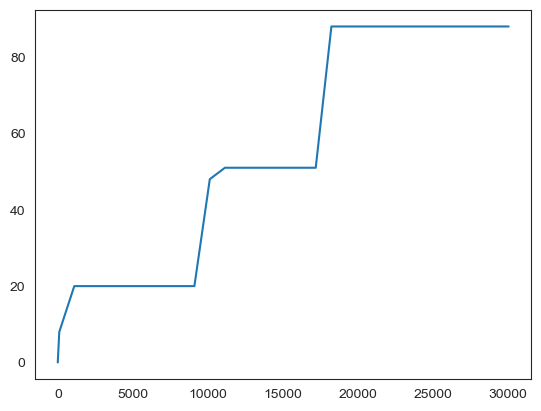

In [14]:
plt.plot(convergence.nfe, convergence.epsilon_progress)

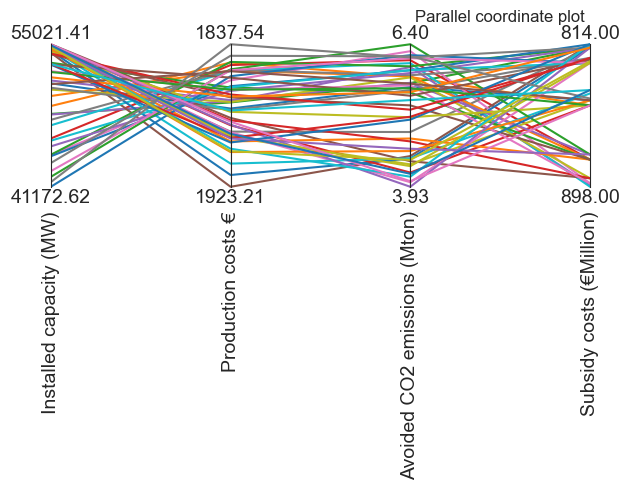

In [19]:
from ema_workbench.analysis import parcoords

data = results.loc[:, ['Installed capacity (MW)', 'Production costs \N{euro sign}', 
                       'Avoided CO2 emissions (Mton)', 'Subsidy costs (\N{euro sign}Million)']]
limits = parcoords.get_limits(data)
limits.loc[:, ['Installed capacity (MW)', 'Production costs \N{euro sign}', 
               'Avoided CO2 emissions (Mton)', 'Subsidy costs (\N{euro sign}Million)']] 

paraxes = parcoords.ParallelAxes(limits)
paraxes.plot(data)
paraxes.invert_axis(['Production costs \N{euro sign}','Subsidy costs (\N{euro sign}Million)'])
plt.title('Parallel coordinate plot', loc='center')
plt.show()

In [20]:
data

,Installed capacity (MW),Production costs €,Avoided CO2 emissions (Mton),Subsidy costs (€Million)
0,51225.300781,1876.187988,5.660676,847.0
1,49016.929688,1848.520752,5.833799,850.0
2,48251.644531,1872.514648,5.728606,816.0
3,45865.445312,1850.030273,6.124740,882.0
4,48191.339844,1871.629395,6.004706,897.0
5,54201.820312,1923.209595,4.465697,814.0
6,44257.507812,1859.247437,6.280337,896.0
7,54372.015625,1890.062988,4.881668,816.0
8,54894.238281,1893.263672,4.321807,847.0
9,47142.925781,1853.608398,6.073911,898.0


In [21]:
results

,Initial ICPEI funds,SDE++ fund,Market value creation[refineries],Share RES allocated to H2,Installed capacity (MW),Production costs €,Avoided CO2 emissions (Mton),Subsidy costs (€Million)
0,47,664,0.856943,0.437428,51225.300781,1876.187988,5.660676,847.0
1,50,728,0.844974,0.691582,49016.929688,1848.520752,5.833799,850.0
2,16,68,0.853222,0.371993,48251.644531,1872.514648,5.728606,816.0
3,82,431,0.755812,0.588026,45865.445312,1850.030273,6.124740,882.0
4,97,763,0.731183,0.368132,48191.339844,1871.629395,6.004706,897.0
5,14,766,1.125953,0.429509,54201.820312,1923.209595,4.465697,814.0
6,96,62,0.688228,0.424033,44257.507812,1859.247437,6.280337,896.0
7,16,68,1.043875,0.572202,54372.015625,1890.062988,4.881668,816.0
8,47,664,1.158592,0.624322,54894.238281,1893.263672,4.321807,847.0
9,98,161,0.754718,0.573999,47142.925781,1853.608398,6.073911,898.0


In [42]:
x = results['Subsidy costs (\N{euro sign}Million)']
p = np.nanpercentile(x,30)
#p = 818
logical = x <p
np.sum(logical)

14

In [43]:
logical

0     False
1     False
2      True
3     False
4     False
5      True
6     False
7      True
8     False
9     False
10     True
11    False
12     True
13    False
14    False
15    False
16    False
17    False
18    False
19    False
20     True
21    False
22    False
23    False
24     True
25    False
26    False
27     True
28    False
29    False
30    False
31    False
32    False
33    False
34     True
35    False
36    False
37     True
38    False
39     True
40     True
41     True
42    False
43     True
44    False
45    False
46    False
47    False
48    False
49    False
50    False
Name: Subsidy costs (€Million), dtype: bool

In [44]:

policies = results[logical]
policies = policies.drop(['Installed capacity (MW)', 'Production costs \N{euro sign}', 'Avoided CO2 emissions (Mton)'
                          , 'Subsidy costs (\N{euro sign}Million)'], axis=1)



,Initial ICPEI funds,SDE++ fund,Market value creation[refineries],Share RES allocated to H2
2,16,68,0.853222,0.371993
5,14,766,1.125953,0.429509
7,16,68,1.043875,0.572202
10,16,68,1.137486,0.479218
12,16,68,0.828069,0.576564
20,14,766,0.816831,0.386594
24,16,68,0.821726,0.375538
27,22,110,0.879069,0.410263
34,16,68,1.285160,0.672749
37,16,68,0.798523,0.651800


In [45]:
df_policies = policies
Candidate_policy=df_policies.index.name
#df_policies.set_index(Candidate_policy)
df_policies.index.name = 'Policy'
df_policies

,Initial ICPEI funds,SDE++ fund,Market value creation[refineries],Share RES allocated to H2
Policy,,,,
2,16,68,0.853222,0.371993
5,14,766,1.125953,0.429509
7,16,68,1.043875,0.572202
10,16,68,1.137486,0.479218
12,16,68,0.828069,0.576564
20,14,766,0.816831,0.386594
24,16,68,0.821726,0.375538
27,22,110,0.879069,0.410263
34,16,68,1.285160,0.672749


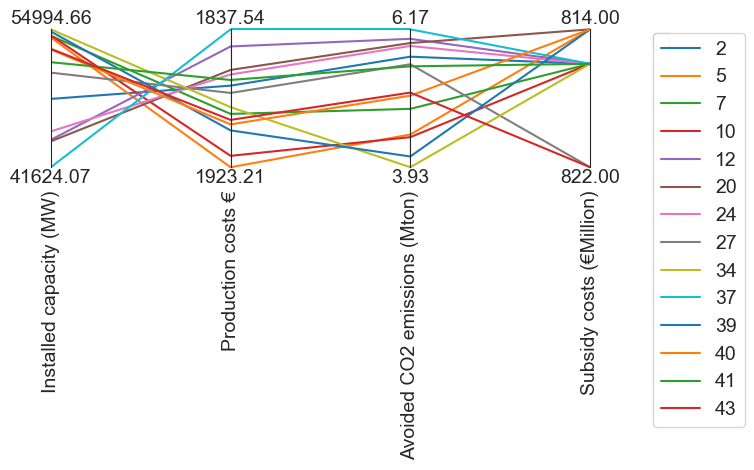

In [49]:
from ema_workbench.analysis import parcoords
results2=results[logical]
colors = sns.color_palette(n_colors=40)
data = results2.loc[:, ['Installed capacity (MW)', 'Production costs \N{euro sign}', 
                       'Avoided CO2 emissions (Mton)', 'Subsidy costs (\N{euro sign}Million)']]
limits = parcoords.get_limits(data)
limits.loc[:, ['Installed capacity (MW)', 'Production costs \N{euro sign}', 
               'Avoided CO2 emissions (Mton)', 'Subsidy costs (\N{euro sign}Million)']] 

paraxes = parcoords.ParallelAxes(limits)
paraxes.legend()
for i, (index, row) in enumerate(data.iterrows()):
    paraxes.plot(row.to_frame().T, label=str(index), color=colors[i])
paraxes.invert_axis(['Production costs \N{euro sign}','Subsidy costs (\N{euro sign}Million)'])
paraxes.legend()
plt.show()

In [50]:
from ema_workbench import Policy

policies_to_evaluate = []

for i, policy in policies.iterrows():
    policies_to_evaluate.append(Policy(str(i), **policy.to_dict()))

In [51]:
n_scenarios = 1000
with MultiprocessingEvaluator(model) as evaluator:
    results_robust = evaluator.perform_experiments(n_scenarios,
                                            policies_to_evaluate,
                                            )

[MainProcess/INFO] pool started with 8 workers
[MainProcess/INFO] performing 1000 scenarios * 14 policies * 1 model(s) = 14000 experiments
100%|████████████████████████████████████| 14000/14000 [58:38<00:00,  3.98it/s]
[MainProcess/INFO] experiments finished
[MainProcess/INFO] terminating pool


In [52]:
def s_to_n(data, direction):
    mean = np.mean(data)
    std = np.std(data)
    
    if direction==ScalarOutcome.MAXIMIZE:
        return mean/std
    else:
        return mean*std

In [53]:
import pandas as pd
Rexperiments, Routcomes = results_robust
Routcomes.keys()
overall_scores = {}
for policy in np.unique(Rexperiments['policy']):
    scores = {}
    
    logical = Rexperiments['policy']==policy
    
    for outcome in model.outcomes:
        value  = Routcomes[outcome.name][logical]
        sn_ratio = s_to_n(value, outcome.kind)
        scores[outcome.name] = sn_ratio
    overall_scores[policy] = scores
scores = pd.DataFrame.from_dict(overall_scores).T


In [54]:
data

,Installed capacity (MW),Production costs €,Avoided CO2 emissions (Mton),Subsidy costs (€Million)
2,48251.644531,1872.514648,5.728606,816.0
5,54201.820312,1923.209595,4.465697,814.0
7,54372.015625,1890.062988,4.881668,816.0
10,54409.359375,1916.125732,4.422458,816.0
12,44281.519531,1848.167358,6.018500,816.0
20,44135.433594,1862.754150,5.950179,814.0
24,45097.613281,1865.568481,5.902724,816.0
27,50795.808594,1877.051025,5.605914,822.0
34,54994.664062,1885.863159,3.934110,816.0
37,41624.070312,1837.536377,6.172340,816.0


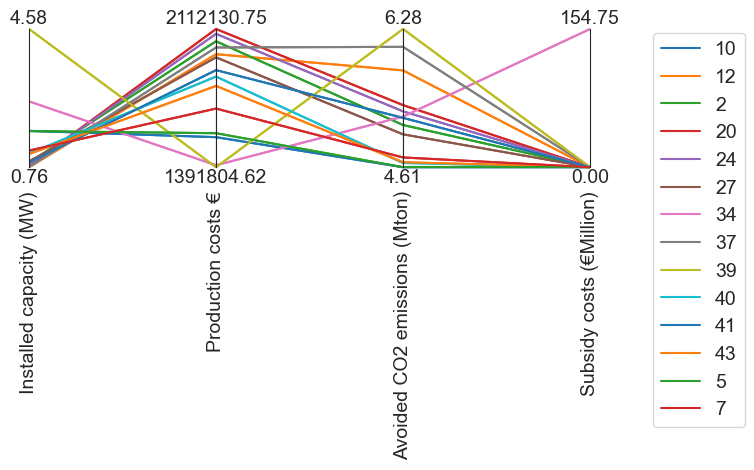

,Installed capacity (MW),Production costs €,Avoided CO2 emissions (Mton),Subsidy costs (€Million)
10,1.764708,1548294.375,4.610626,0.000000
12,0.761620,1980884.500,5.776589,0.000000
2,0.883971,2048158.125,5.118996,0.000000
20,0.790741,2112130.750,5.358335,0.000000
24,0.820564,2086790.625,5.283248,0.000000
27,0.919177,1964310.375,5.006593,0.000000
34,2.579448,1402168.375,5.220424,154.748779
37,0.758936,2015871.125,6.060575,0.000000
39,4.582077,1391804.625,6.275671,0.000000
40,1.137096,1864162.125,4.661678,0.000000


In [55]:
from ema_workbench.analysis import parcoords

colors = sns.color_palette(n_colors=40)
data = scores
data = data.loc[:, ['Installed capacity (MW)', 'Production costs \N{euro sign}', 
                    'Avoided CO2 emissions (Mton)', 'Subsidy costs (\N{euro sign}Million)']] 
limits = parcoords.get_limits(data)
limits.loc[:, ['Installed capacity (MW)', 'Production costs \N{euro sign}', 
               'Avoided CO2 emissions (Mton)', 'Subsidy costs (\N{euro sign}Million)']] 

paraxes = parcoords.ParallelAxes(limits)
paraxes.plot(data)
#paraxes.invert_axis(['Production costs \N{euro sign}', 'Subsidy costs (\N{euro sign}Million)'])
for i, (index, row) in enumerate(data.iterrows()):
    paraxes.plot(row.to_frame().T, label=str(index), color=colors[i])
paraxes.legend()
plt.show()
data.loc[:, ['Installed capacity (MW)', 'Production costs \N{euro sign}', 
             'Avoided CO2 emissions (Mton)', 'Subsidy costs (\N{euro sign}Million)']] 


In [56]:
def calculate_regret(data, best):
    return np.abs(best-data)

In [57]:
Rexperiments

,Allocation key,Allocation key SDE,Average GDP growth,Biofuel price,Business cycle,CO2 elasticity,Coal price,Demand substitution rate,Domestic electrification,Efficiency increase,...,Short term price effect,Substitution delay,Transport fuel substitution rate,Initial ICPEI funds,SDE++ fund,Market value creation[refineries],Share RES allocated to H2,scenario,policy,model
0,0.024394,0.151410,0.013771,1991.353202,5.559085,0.713973,97.074598,0.337735,0.044498,0.019120,...,0.260993,2.077503,0.162312,16.0,68.0,0.853222,0.371993,0,2,simpleModel
1,0.187397,0.189842,0.026133,1926.600767,5.113013,0.421496,73.280107,1.092057,0.043960,0.015547,...,0.285790,2.655257,0.183620,16.0,68.0,0.853222,0.371993,1,2,simpleModel
2,0.174518,0.096564,0.024332,2041.826981,5.358092,0.774191,96.724410,1.981168,0.036901,0.012838,...,0.123268,2.843616,0.180915,16.0,68.0,0.853222,0.371993,2,2,simpleModel
3,0.170679,0.197147,0.017302,2065.874180,5.442812,0.449053,92.540265,0.461589,0.049491,0.017688,...,0.205396,2.669153,0.129590,16.0,68.0,0.853222,0.371993,3,2,simpleModel
4,0.082401,0.160986,0.015025,2041.013163,5.184342,0.532815,81.803731,1.244449,0.038274,0.018206,...,0.209495,3.739673,0.109325,16.0,68.0,0.853222,0.371993,4,2,simpleModel
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13995,0.157460,0.177089,0.025137,1927.111827,5.837361,0.648388,70.902591,1.457854,0.038982,0.012858,...,0.247488,2.382775,0.159024,22.0,110.0,0.970023,0.436804,995,43,simpleModel
13996,0.095503,0.045408,0.022765,2039.017623,5.154952,0.685116,89.325419,0.676870,0.048471,0.018310,...,0.233177,3.692227,0.177115,22.0,110.0,0.970023,0.436804,996,43,simpleModel
13997,0.168655,0.053356,0.015598,2061.781121,5.158995,0.750460,93.737082,1.780756,0.044259,0.013788,...,0.235335,3.793031,0.196630,22.0,110.0,0.970023,0.436804,997,43,simpleModel
13998,0.147434,0.165972,0.010325,1900.822268,5.793720,0.480637,79.677581,1.546653,0.036612,0.015387,...,0.275370,2.225187,0.185862,22.0,110.0,0.970023,0.436804,998,43,simpleModel


In [58]:
Routcomes.pop('TIME')
Routcomes
df = pd.DataFrame(Routcomes)
df[['Installed capacity (MW)', 'Production costs \N{euro sign}', 'Avoided CO2 emissions (Mton)', 'Subsidy costs (\N{euro sign}Million)']]

,Installed capacity (MW),Production costs €,Avoided CO2 emissions (Mton),Subsidy costs (€Million)
0,1712.142090,3682.464355,14.618557,816.0
1,13258.156250,2025.441650,10.725475,816.0
2,1269.150269,3786.735352,18.653843,816.0
3,14693.481445,2223.467041,9.752838,816.0
4,3542.839844,3061.176514,13.828608,816.0
...,...,...,...,...
13995,1838.426270,2665.663086,14.584493,822.0
13996,38315.039062,2143.955078,10.233304,822.0
13997,69023.882812,2276.866699,13.365076,822.0
13998,33813.011719,2383.318604,15.972303,822.0


In [59]:
#experiments, outcomes = results

overall_regret = {}
max_regret = {}
for outcome in Routcomes:
    policy_column = Rexperiments['policy']
    
    # create a DataFrame with all the relevent information
    # i.e., policy, scenario_id, and scores
    data = pd.DataFrame({outcome: Routcomes[outcome], 
                         "policy":Rexperiments['policy'],
                         "scenario":Rexperiments['scenario']})
    
    # reorient the data by indexing with policy and scenario id
    data = data.pivot(index='scenario', columns='policy')
    
    # flatten the resulting hierarchical index resulting from 
    # pivoting, (might be a nicer solution possible)
    data.columns = data.columns.get_level_values(1)
    
    # we need to control the broadcasting. 
    # max returns a 1d vector across scenario id. By passing
    # np.newaxis we ensure that the shape is the same as the data
    # next we take the absolute value
    #
    # basically we take the difference of the maximum across 
    # the row and the actual values in the row
    #
    outcome_regret = (data.max(axis=1)[:, np.newaxis] - data).abs()
    
    overall_regret[outcome] = outcome_regret
    max_regret[outcome] = outcome_regret.max()


C:\Users\bern\AppData\Local\Temp\ipykernel_10668\868640897.py:29: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  outcome_regret = (data.max(axis=1)[:, np.newaxis] - data).abs()
C:\Users\bern\AppData\Local\Temp\ipykernel_10668\868640897.py:29: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  outcome_regret = (data.max(axis=1)[:, np.newaxis] - data).abs()
C:\Users\bern\AppData\Local\Temp\ipykernel_10668\868640897.py:29: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  outcome_regret = (data.max(axis=1)[:, np.newaxis] - data).abs()
C:\Users\bern\AppData\Local\Temp\ipykernel_10668\868640897

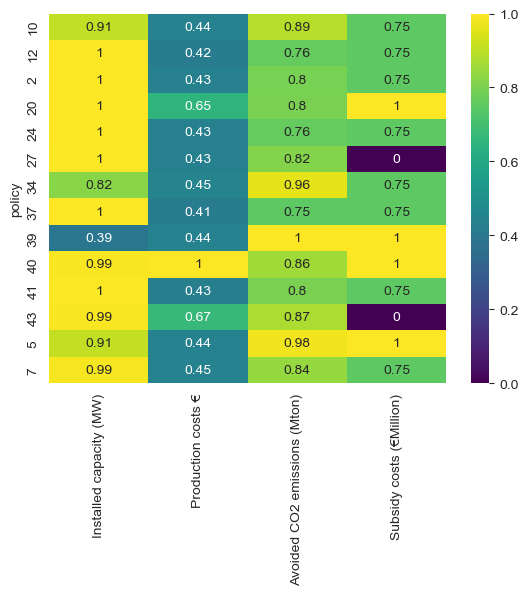

In [60]:
import seaborn as sns
max_regret = pd.DataFrame(max_regret)
sns.heatmap(max_regret/max_regret.max(), cmap='viridis', annot=True)
plt.show()

In [61]:
max_regret

,Installed capacity (MW),Production costs €,Avoided CO2 emissions (Mton),Subsidy costs (€Million)
policy,,,,
10,75824.656250,2138.303955,10.355350,6.0
12,83652.539062,2010.314941,8.896001,6.0
2,83537.976562,2088.464355,9.278730,6.0
20,83715.460938,3143.581543,9.335060,8.0
24,83685.632812,2087.755859,8.889005,6.0
27,83367.031250,2084.569092,9.508916,0.0
34,69006.843750,2188.327637,11.170065,6.0
37,83726.281250,2002.429443,8.779445,6.0
39,32733.128906,2140.432617,11.663131,8.0


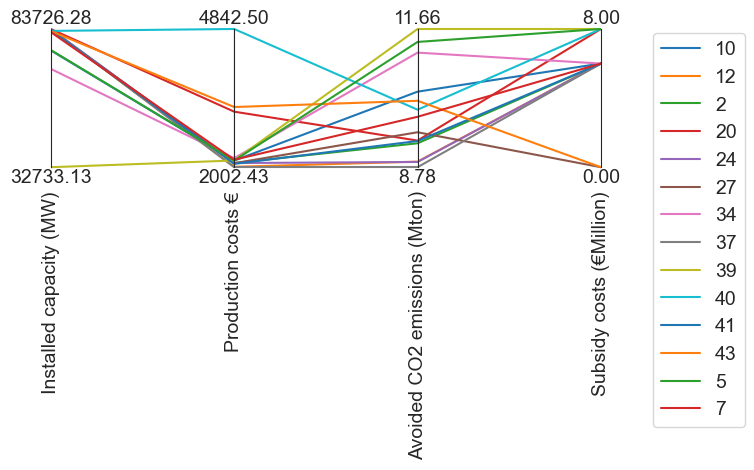

In [62]:

colors = sns.color_palette(n_colors=40)

data = max_regret

# makes it easier to identify the policy associated with each line
# in the parcoords plot
# data['policy'] = data.index.astype("float64")

limits = parcoords.get_limits(data)
limits.loc[:, ['Installed capacity (MW)', 'Production costs \N{euro sign}', 'Avoided CO2 emissions (Mton)', 'Subsidy costs (\N{euro sign}Million)']]
paraxes = parcoords.ParallelAxes(limits)
for i, (index, row) in enumerate(data.iterrows()):
    paraxes.plot(row.to_frame().T, label=str(index), color=colors[i])
paraxes.legend()

    
plt.show()

In [63]:
from collections import defaultdict

policy_regret = defaultdict(dict)
for key, value in overall_regret.items():
    for policy in value:
        policy_regret[policy][key] = value[policy]




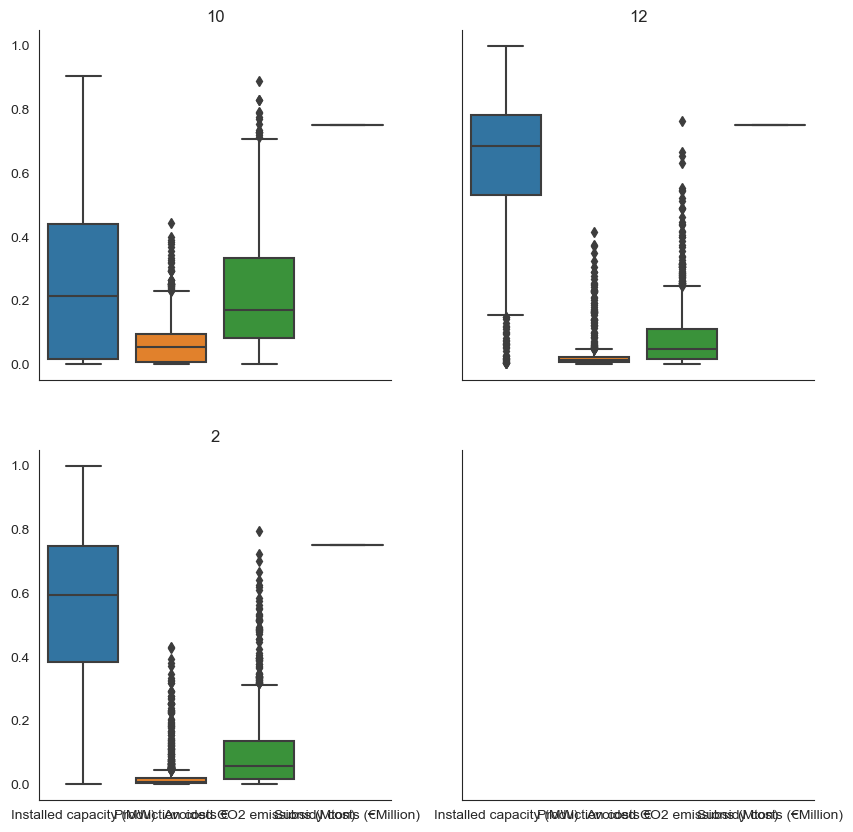

In [64]:
# this generates a 2 by 2 axes grid, with a shared X and Y axis
# accross all plots
fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(10,10), 
                         sharey=True, sharex=True)

# to ensure easy iteration over the axes grid, we turn it
# into a list. Because there are four plots, I hard coded
# this. 
axes = [axes[0,0], axes[0,1],
        axes[1,0],]

# zip allows us to zip together the list of axes and the list of 
# key value pairs return by items. If we iterate over this
# it returns a tuple of length 2. The first item is the ax
# the second items is the key value pair.
for ax, (policy, regret) in zip(axes, policy_regret.items()):
    data = pd.DataFrame(regret)

    # we need to scale the regret to ensure fair visual
    # comparison. We can do that by divding by the maximum regret
    data = data/max_regret.max(axis=0)
    sns.boxplot(data=data, ax=ax)
    
    # removes top and left hand black outline of axes
    sns.despine()
    
    # ensure we know which policy the figure is for
    ax.set_title(str(policy))
plt.show()